In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [39]:
type_training = ["SPEED", "ENDURANCE", "RECUPERATION"]   # Niveau 1
interval = ["short vma", "hills", "threshold", "fatleck", "cold water", "footing"]        # Niveau 2


# Initialization of the scores 
scores_type = np.zeros(len(type_training))
scores_interval = np.zeros((len(type_training), len(interval)))


def simulate_reward(type, interval):
    reward_matrix = {
        "SPEED": {"short vma": 1.4, "hills": 0.3},   
        "ENDURANCE": {"threshold": 2.9, "fatleck": 1.6},
        "RECUPERATION": {"cold water": 0.1, "footing": 1.4}
    }
    if type not in reward_matrix or interval not in reward_matrix[type]:
        raise KeyError(f"Invalid type or interval: type={type}, interval={interval}")
    return reward_matrix[type][interval] + np.random.normal(0, 0.5)

optimal_rewards = {
    "SPEED": 1.4,
    "ENDURANCE": 2.9,
    "RECUPERATION": 1.4,
}

print(optimal_rewards)

def softmax(scores, mu):
    exp_scores = np.exp(scores / mu)
    return exp_scores / exp_scores.sum()

def normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores) + 1e-9)

def return_intervals(idx_type):
    if idx_type == 0:
        return ["short vma", "hills"], [0, 1]
    elif idx_type == 1:
        return ["threshold", "fatleck"], [2, 3]
    else:
        return ["cold water", "footing"], [4, 5]

{'SPEED': 1.4, 'ENDURANCE': 2.9, 'RECUPERATION': 1.4}


In [40]:
n_iterations = 10 ** 4
L = 2
n_l = 2
Rl_bar = 1    # We assume R_S = 1
n_eff = (L * np.sqrt(n_l) * Rl_bar) ** 2
mu = np.sqrt(n_eff / 2)     # sqrt(n_eff / 2)
regret = []
cumulative_regret = 0

for t in range(1, n_iterations + 1):
    eta = np.sqrt(np.log(n_iterations) / (2 * t))  # Theorem 
    
    # Backward phase 
    for layer in range(L, 0, -1):
        if layer == L:
            pass  # No need to update scores of intervals at this step
        else:  # Update scores of the types
            for index, type in enumerate(["SPEED", "ENDURANCE", "RECUPERATION"]): 
                sub_intervals, indx = return_intervals(index)
                sub_scores = scores_interval[index, indx]
                scores_type[index] = mu * np.log(
                    np.sum(np.exp(sub_scores / mu))
                )
    
    scores_type = normalize(scores_type)
    # End of backward phase 

    r_hat = np.zeros((len(type_training), len(interval)))
    
    # Forward phase
    # Select class of layer 1
    prob_type = softmax(scores_type, mu)
    idx_type = np.random.choice(len(type_training), p=prob_type)
    selected_training = type_training[idx_type]
    score_selected_training = scores_type[idx_type]

    # Select class of layer 2
    name_intervals, idx = return_intervals(idx_type)
    sub_intervals = scores_interval[idx_type, idx]
    prob_interval_layer_2_selected = np.exp(eta * sub_intervals / mu)
    prob_interval_layer_2_selected /= np.sum(prob_interval_layer_2_selected)
    idx_interval = np.random.choice(len(sub_intervals), p=prob_interval_layer_2_selected)
    r = simulate_reward(selected_training, name_intervals[idx_interval])
    r_hat[idx_type, idx[idx_interval]] += r / prob_interval_layer_2_selected[idx_interval]
    # End of forward phase
    
    # Update scores
    for idx_type in range(len(type_training)):
        name_intervals, idx = return_intervals(idx_type)
        for local_idx, global_idx in enumerate(idx):
            scores_interval[idx_type, global_idx] -= r_hat[idx_type, global_idx]
    
    # Normalize scores
    for idx_type in range(len(type_training)):
        scores_interval[idx_type] = normalize(scores_interval[idx_type])

    # Regret 
    optimal_reward = optimal_rewards[selected_training]
    cumulative_regret += (optimal_reward - r)
    regret.append(cumulative_regret)

# Résultats finaux
print("Final scores of trainings:")
for i, type in enumerate(type_training):
    print(f"{type}: {scores_type[i]:.2f}")

print("\nFinal scores of intervals:")
for i, type in enumerate(type_training):
    sub_intervals, idx = return_intervals(i)
    for local_idx, global_idx in enumerate(idx):
        print(f"{type} - {sub_intervals[local_idx]}: {scores_interval[i, global_idx]:.2f}")

Final scores of trainings:
SPEED: 1.00
ENDURANCE: 0.68
RECUPERATION: 0.00

Final scores of intervals:
SPEED - short vma: 0.00
SPEED - hills: 1.00
ENDURANCE - threshold: 0.90
ENDURANCE - fatleck: 0.00
RECUPERATION - cold water: 0.74
RECUPERATION - footing: 0.00


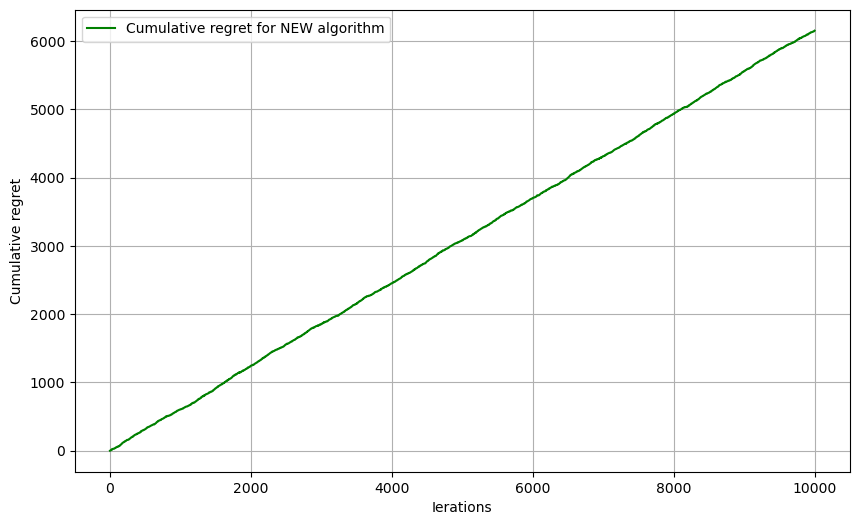

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), regret, label = "Cumulative regret for NEW algorithm", color = "green")
plt.xlabel("Ierations")
plt.ylabel("Cumulative regret")
plt.legend()
plt.grid()
plt.show()

Problèmes : 
- L'algorithme discrimine mal lorsqu'une solution est vraiment optimale. 
- Nécessité de connaître la structure. 